# OPENTIS
## An Example with Alanine

Import Modules

In [1]:
import numpy as np
import mdtraj as md
import pandas as pd
import time
import sys, os
 
# in principle, all of these imports should be simplified once this is a package
from openpathsampling.collectivevariable import CV_Function, CV_Volume, CV_MD_Function
from openpathsampling.snapshot import Snapshot
from openpathsampling.volume import LambdaVolumePeriodic, VolumeFactory as vf
from openpathsampling.pathmover import PathMoverFactory as mf
from openpathsampling.ensemble import EnsembleFactory as ef
from openpathsampling.ensemble import (LengthEnsemble, SequentialEnsemble, AllOutXEnsemble,
                      AllInXEnsemble, PartInXEnsemble, PartOutXEnsemble)
from openpathsampling.storage import Storage
from openpathsampling.trajectory import Trajectory
from openpathsampling.pathsimulator import Bootstrapping
from openpathsampling.shooting import UniformSelector
from openpathsampling.pathmover import PathMover
import simtk.unit as u

from openpathsampling.openmm_engine import OpenMMEngine

from openpathsampling.storage import Storage
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

import openpathsampling as paths

Radians to Degree conversion

In [2]:
degrees = 180/3.14159 # psi reports in radians; I think in degrees

Create an AlanineOpenMMSimulator for demonstration purposes

### Set simulation options and create a simulator object

In [3]:
options = {
            'temperature' : 300.0 * u.kelvin,
            'collision_rate' : 1.0 / u.picoseconds,
            'timestep' : 2.0 * u.femtoseconds,
            'nsteps_per_frame' : 10,
            'n_frames_max' : 5000,
            'start_time' : time.time(),
            'fn_initial_pdb' : "../data/Alanine_solvated.pdb",
            'platform' : 'fastest',
            'solute_indices' : range(22),
            'forcefield_solute' : 'amber96.xml',
            'forcefield_solvent' : 'tip3p.xml'
           }

In [4]:
engine = OpenMMEngine.auto(
                filename="trajectory.nc",
                template="../data/Alanine_solvated.pdb",
                options=options,
                mode='create'
                )

And save the storage in a separate variable for convenience

In [5]:
storage = engine.storage
PathMover.engine = engine

Equilibrate

In [6]:
engine.current_snapshot = engine.template
engine.equilibrate(5)
engine.initialized = True

Save equilibrated snapshot with index 0

In [7]:
storage.save(engine.current_snapshot);

### Order Parameters

this generates an order parameter (callable) object named psi (so if we call `psi(trajectory)` we get a list of the values of psi for each frame in the trajectory). This particular order parameter uses mdtraj's compute_dihedrals function, with the atoms in psi_atoms

In [8]:
psi_atoms = [6,8,14,16]
psi = CV_MD_Function("psi", md.compute_dihedrals,
                  indices=[psi_atoms])

phi_atoms = [4,6,8,14]
phi = CV_MD_Function("phi", md.compute_dihedrals,
                  indices=[phi_atoms])

In [9]:
sim = paths.todict.ObjectJSON()

In [10]:
a = sim.to_json_object(psi)

In [11]:
type(sim.from_json(a))

openpathsampling.collectivevariable.CV_MD_Function

In [12]:
t = CV_Function("test", lambda x : x)

In [13]:
storage.save(t)

True

In [14]:
storage.save([psi, phi]);

### Volumes

This creates two states using a one-dimensional order parameter (called _Lambda_ in TIS terminology). A snapshot is in the State as long as the order parameter is with specific bounds. 

In [15]:
stateA = LambdaVolumePeriodic(
    collectivevariable=psi, 
    lambda_min=-120.0/degrees, 
    lambda_max=-30.0/degrees, 
    period_min=-180.0/degrees, 
    period_max=+180.0/degrees
)
stateB = LambdaVolumePeriodic(psi, 100/degrees, 180/degrees, -180.0/degrees, +180.0/degrees)

Now do the same for a set of lambda ranges to produce nested volumes.

In [16]:
minima = map((1.0 / degrees).__mul__,
             [-125, -135, -140, -142.5, -145.0, -147.0, -150.0])

maxima = map((1.0 / degrees).__mul__,
             [-25.0, -21.0, -18.5, -17.0, -15.0, -10.0, 0.0])

volume_set = vf.LambdaVolumePeriodicSet(psi, minima, maxima, -180.0/degrees, +180.0/degrees)

### Ensembles

Now do this automatically for all ensembles

In [17]:
interface0 = volume_set[0]
interface_set = ef.TISEnsembleSet(stateA, stateA | stateB, volume_set)
for no, interface in enumerate(interface_set):
    # Give each interface a name
    interface.uid = 'Interface '+str(no)
    # And save all of these
    storage.ensembles.save(interface)

And create a special ensemble, that will create a first trajectory in the innermost TIS ensemble independent from where we start

The idea is to describe a trajectory type by a sequence of positions. First can be outside of stateA or not, then be inside stateA, etc...

In [18]:
first_traj_ensemble = SequentialEnsemble([
    AllOutXEnsemble(stateA) | LengthEnsemble(0),
    AllInXEnsemble(stateA),
    (AllOutXEnsemble(stateA) & AllInXEnsemble(interface0)) | LengthEnsemble(0),
    AllInXEnsemble(interface0) | LengthEnsemble(0),
    AllOutXEnsemble(interface0),
    AllOutXEnsemble(stateA) | LengthEnsemble(0),
    AllInXEnsemble(stateA) & LengthEnsemble(1)
])

In [19]:
platform = engine.simulation.context.getPlatform()
print platform.getName()

CUDA


### start path generation

so lets try and see if we can generate a first path

load the initial snapshot (although we still have it) and generate using the Alanine simulator. The second option specifies a function : trajectory -> bool that keeps the simulation running as long as it is true. Our goal was to generate a path that belongs to a specific ensemble, so we use `forward` to determine if it makes sense to keep running or if the result cannot belong to the ensemble anymore.

In [20]:
snapshot = storage.load(Snapshot, 0)
total_path = engine.generate(
    snapshot= snapshot, 
    running = [first_traj_ensemble.can_append]
)

Show the length

In [21]:
print "Total trajectory length: ", len(total_path)

Total trajectory length:  23


And save the trajetory completely

In [22]:
storage.save(total_path);

Split the trajectory into parts that belong to the TIS ensemble (not the one we generated)

In [23]:
interface0_ensemble = interface_set[0]
segments = interface0_ensemble.split(total_path)

print "Traj in first_traj_ensemble? (should be)", 
print first_traj_ensemble(total_path)

print "Traj in TIS ensemble? (probably not)", 
print interface0_ensemble(total_path)


print "Number of segments in TIS ensemble: ", len(segments)
if len(segments):
    print "Length of each segment:"
    for i in range(len(segments)):
        print "  seg[{0}]: {1}".format(i, len(segments[i]))

Traj in first_traj_ensemble? (should be) True
Traj in TIS ensemble? (probably not) False
Number of segments in TIS ensemble:  1
Length of each segment:
  seg[0]: 8


Show some results and check if this worked

In [24]:
data = []
for frame in total_path:
    data.append((phi(frame)[0]*degrees, psi(frame)[0]*degrees, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]].ix[[0,1,2,len(dataframe)-3,len(dataframe)-2,len(dataframe)-1]]

,phi,psi,stateA,interface0,stateB,appendable
0,-80.208523,-10.277041,[False],[False],[False],True
1,-83.571397,-11.666149,[False],[False],[False],True
2,-78.804795,-12.417985,[False],[False],[False],True
20,-88.321797,-24.115981,[False],[False],[False],True
21,-85.498680,-29.853273,[False],[True],[False],True
22,-80.182131,-33.170244,[True],[True],[False],False


In [25]:
print "Do our segments satisfy the ensemble?",
for seg in segments:
    print interface0_ensemble(seg),

Do our segments satisfy the ensemble? True


In [26]:
data = []
for frame in segments[0]:
    data.append((phi(frame)[0]*degrees, psi(frame)[0]*degrees, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]]

,phi,psi,stateA,interface0,stateB,appendable
0,-72.813956,-31.873170,[True],[True],[False],True
1,-80.226076,-24.757107,[False],[False],[False],True
2,-79.763870,-23.350375,[False],[False],[False],True
3,-86.162752,-20.847546,[False],[False],[False],True
4,-90.512145,-21.019425,[False],[False],[False],True
5,-88.321797,-24.115981,[False],[False],[False],True
6,-85.498680,-29.853273,[False],[True],[False],True
7,-80.182131,-33.170244,[True],[True],[False],False


### Bootstrapping

Run a bootstrapping (not TIS) simulation that shoots from an ensemble until the next interface is reached then switch to the next ensemble to drive the system out of stateA

In [27]:
mover_set = mf.OneWayShootingSet(UniformSelector(), interface_set)

In [28]:
bootstrap = Bootstrapping(storage=storage,
                          engine=engine,
                          ensembles=interface_set,
                          movers=mover_set,
                          trajectory=segments[0])

Run Bootstrapping with at most 50 attempts per ensemble

In [29]:
bootstrap.run(20)

Save all computed phi/psi values which depends on whether they have been needed before

In [30]:
storage.collectivevariables.sync(psi);
storage.collectivevariables.sync(phi);

Create an collectivevariable from a volume which is just 1 or 0 and can thus be stored for later analysis

In [31]:
op_inA = CV_Volume('StateA', stateA)
op_inA.uid = 'StateA'
op_inB = CV_Volume('StateB', stateB)
op_inB.uid = 'StateB'
op_notinAorB = CV_Volume('StateX', ~ (stateA | stateB))
op_notinAorB.uid = 'StateX'

Compute the collectivevariable for all snapshots

In [32]:
#op_inA(storage.snapshots)
#op_inB(storage.snapshots)
#op_notinAorB(storage.snapshots);

Save the new collectivevariables

In [33]:
storage.save([op_inA, op_inB, op_notinAorB]);
storage.cvs.sync()
storage.sync()

In [34]:
storage.close()

In [1]:
import openpathsampling as paths
from openpathsampling.visualize import PathTreeBuilder

In [2]:
storage = paths.storage.Storage('trajectory.nc', mode='r')

## Visualization

Create a PathTree generator

In [3]:
storage.cvs.cache = dict()

In [10]:
tree = PathTreeBuilder(storage)
#storage.save(op_inA)
cv0 = storage.cvs[0]
cv1 = storage.cvs[1]

In [29]:
s = storage.snapshots[10]
s2 = paths.Snapshot(configuration=s.configuration, momentum=s.momentum, reversed=s.reversed)

In [11]:
cv1.name

'psi'

In [14]:
cv1.kwargs

{'indices': [[6, 8, 14, 16]]}

In [16]:
cv1._topology

In [23]:
t = storage.trajectories[0].md()

In [24]:
t

<mdtraj.Trajectory with 23 frames, 1651 atoms, 546 residues, without unitcells at 0x11154e650>

In [34]:
cv1(s)

-0.5960095524787903

In [33]:
cv1.fcn(t, **cv1.kwargs)[10]

array([-0.58963156], dtype=float32)

Change the settings to show rejected pathways, mark OrderParaemters `stateA` and `stateX`, and show the 'psi' value as text inside of the boxes

In [10]:
s = storage.samples[len(storage.samples) - 2]

In [11]:
d = s.details
print d.__dict__
print s.parent

{'trial': Trajectory[11], 'selection_probability': 0.7777777777777778, 'final_point': <openpathsampling.shooting.ShootingPoint object at 0x1113e7690>, 'start': Trajectory[9], 'json': u'{"_cls": "SampleDetails", "_dict": {"trial": {"_idx": 25, "_cls": "Trajectory"}, "selection_probability": 0.7777777777777778, "final_point": {"_idx": 46, "_cls": "ShootingPoint"}, "start": {"_idx": 24, "_cls": "Trajectory"}, "start_point": {"_idx": 47, "_cls": "ShootingPoint"}, "acceptance_probability": 0.7777777777777778}}', '_idx': {Storage @ 'trajectory.nc': 105}, 'start_point': <openpathsampling.shooting.ShootingPoint object at 0x1113e7310>, 'acceptance_probability': 0.7777777777777778}
Step: -1
Replica: 4
Trajectory: Trajectory[9]
Ensemble: <openpathsampling.ensemble.TISEnsemble object at 0x1113e7510>



In [12]:
[cv.__class__ for cv in list(storage.cvs)]

[openpathsampling.collectivevariable.CV_Function,
 openpathsampling.collectivevariable.CV_MD_Function,
 openpathsampling.collectivevariable.CV_MD_Function,
 openpathsampling.collectivevariable.CV_Volume,
 openpathsampling.collectivevariable.CV_Volume,
 openpathsampling.collectivevariable.CV_Volume]

In [13]:
c = storage.cvs[2]

In [14]:
import copy

In [15]:
s = storage.snapshots[10]
s2 = paths.Snapshot(configuration=s.configuration, momentum=s.momentum, reversed=s.reversed)

In [16]:
print id(s)
print id(s2)

4545090448
4589564048


In [17]:
print c(s2)
print c(s)

TypeError: compute_dihedrals() takes exactly 4 arguments (2 given)

In [19]:
print type(c)
print c.__dict__

<class 'openpathsampling.collectivevariable.CV_MD_Function'>
{'store_dict': {}, 'func_dict': {}, 'single_dict': {}, 'name': 'phi', 'expand_dict': {}, 'pre_dict': {}, '_topology': <mdtraj.Topology with 2 chains, 546 residues, 1651 atoms, 1107 bonds at 0x10ee893d0>, '_stored': False, 'json': u'{"_cls": "CV_MD_Function", "_dict": {"name": "phi", "fcn": {"_marshal": "YwQAAAAIAAAADAAAAEMgAQBz0AEAAHQAAHwAAGoBAGQBAHQCAGoDAGQCAGQDAGQEAGQFAGQGAGQPAGQHAHQFAIMBBX0EAHQAAHwBAGQBAHQCAGoGAGQCAGQIAGQEAGQJAGQGAGQQAGQHAHQFAIMBBX0FAHQCAGoHAHQCAGoIAHwFAHwAAGoJAGsAAHwFAGQLAGsFAIMCAIMBAHOdAHQKAGQMAHwAAGoJABaDAQCCAQBuAAB0CwB8BQCDAQBkCwBrAgBy0QB0AgBqDAB0CwB8BACDAQBkCwBmAgBkAQB0AgBqAwCDAQFTdAIAagwAfAQAag0AZAsAGXwFAGoNAGQLABlmAgBkAQB0AgBqAwCDAQF9BgB8AgB0DgBrCABykQF8AABqDwBykQF0AAB8AABqEABkAQB0AgBqAwBkAgBkAwBkBABkDQBkBgB0CwB8BACDAQBkAwBkAwBmAwCDAQR9BwB8AwBydwF0EQBqEgCDAABydwF0EQBqEwB8BAB8BQB8BwB8BgCDBAABfAYAU3QUAHwAAHwFAHwCAHwGAIMEAAF8BgBTbgAAfAMAcrkBdBEAahIAgwAAcrkBdBEAahQAfAQAfAUAfAYAgwMAAW4TAHQUAHwAAHwFAHwCAH

In [69]:
c(storage.snapshots)

[array([-1.39990163], dtype=float32),
 array([-1.4294039], dtype=float32),
 array([-1.43816793], dtype=float32),
 array([-1.4257555], dtype=float32),
 array([-1.37578321], dtype=float32),
 array([-1.43610048], dtype=float32),
 array([-1.34677982], dtype=float32),
 array([-1.30474138], dtype=float32),
 array([-1.26747787], dtype=float32),
 array([-1.26927555], dtype=float32),
 array([-1.21361303], dtype=float32),
 array([-1.18350244], dtype=float32),
 array([-1.0822016], dtype=float32),
 array([-1.10694611], dtype=float32),
 array([-1.14822364], dtype=float32),
 array([-1.18098223], dtype=float32),
 array([-1.21858442], dtype=float32),
 array([-1.19671249], dtype=float32),
 array([-1.20988548], dtype=float32),
 array([-1.25353277], dtype=float32),
 array([-1.21757996], dtype=float32),
 array([-1.2783308], dtype=float32),
 array([-1.31084633], dtype=float32),
 array([-1.26176858], dtype=float32),
 array([-1.3040204], dtype=float32),
 array([-1.20522153], dtype=float32),
 array([-1.227814

In [51]:
tree.rejected = True
tree.states = { 'orange' : storage.cvs[3] }
# Some ideas for collectivevariables to visualize
tree.op = lambda snap : 'B' if snap.reversed else 'F'
tree.op = lambda snap : int(psi(snap)[0]/3.1415926 * 180)
tree.op = storage.configurations.op_idx


tree.from_samples(tree.construct_heritage(storage, storage.samples[len(storage.samples) - 2]))

Render the tree

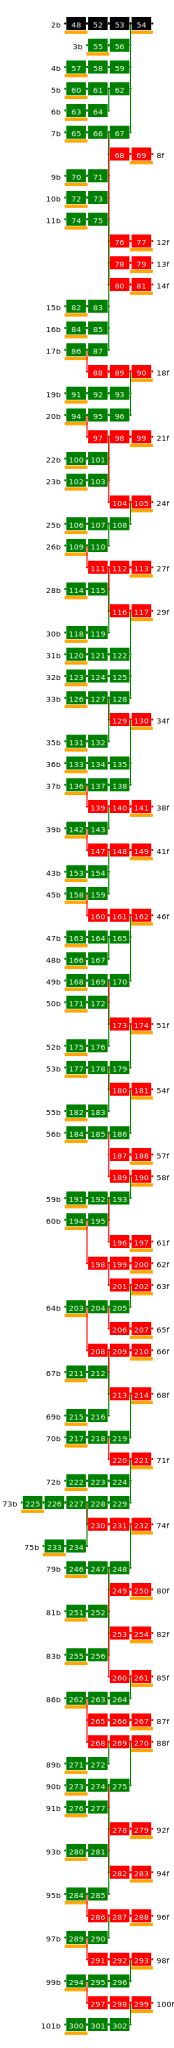

In [52]:
view = tree.renderer
view.zoom = 1.1
view.scale_y = 24
view.scale_x = 24
view.font_size = 0.35
SVG(view.to_svg())

An alternate view which is similar to the standard way of plotting

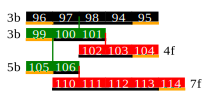

In [45]:
tree.rejected = False
tree.states = []
tree.op = None
samples = storage.samples.by_ensemble(storage.ensembles.load(4))
tree.from_samples(samples)
view = tree.renderer
view.zoom = 1.1
view.horizontal_gap = -0.01
view.scale_y = 15
view.scale_x = 24
view.font_size = 0.8
view.font_family = 'Times'
SVG(view.to_svg())

### Phi/Psi Plots

In [46]:
# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D

Make sure that all phi/psi values have been computed!

In [47]:
phi(storage.snapshots.all());
psi(storage.snapshots.all());

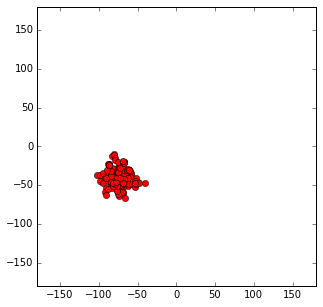

In [48]:
plt.figure(figsize=(5, 5))

for traj in storage.trajectories.iterator():
    phi_angles = degrees * np.array(phi(traj)).flatten()
    psi_angles = degrees * np.array(psi(traj)).flatten()
    plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    
plt.xlim(-180, 180);
plt.ylim(-180, 180);

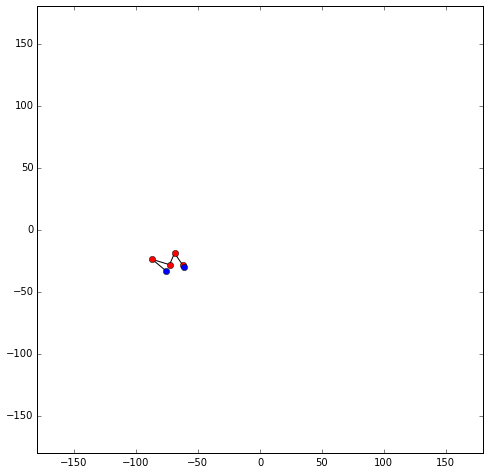

In [49]:
plt.figure(figsize=(8, 8))

traj = storage.trajectories.last()
phi_angles = degrees * np.array(phi(traj)).flatten()
psi_angles = degrees * np.array(psi(traj)).flatten()
plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);

for snapshot in traj:
    phi_angles = degrees * np.array(phi(snapshot)).flatten()
    psi_angles = degrees * np.array(psi(snapshot)).flatten()
    if op_notinAorB(snapshot):
        plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    else:
        plt.plot(phi_angles, psi_angles, 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);

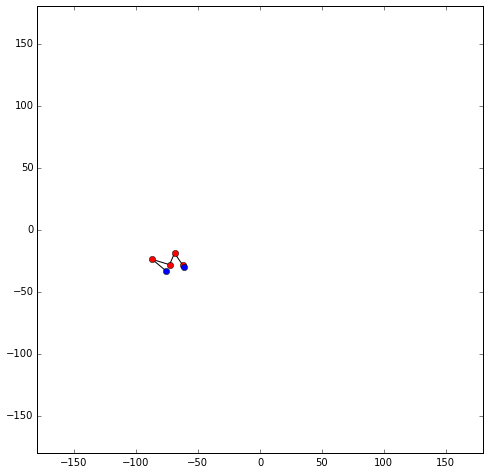

In [50]:
plt.figure(figsize=(8, 8))

traj = storage.samples.last().trajectory
phi_angles = degrees * np.array(phi(traj)).flatten()
psi_angles = degrees * np.array(psi(traj)).flatten()
plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);


#for snapshot in simulator.storage.snapshot.iterator():
for snapshot in traj:
    phi_angles = degrees * np.array(phi(snapshot)).flatten()
    psi_angles = degrees * np.array(psi(snapshot)).flatten()
    if op_notinAorB(snapshot):
        plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    else:
        plt.plot(phi_angles, psi_angles, 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);

In [51]:
storage.cvs.sync()
storage.sync()

In [62]:
pickle.dumps(md.compute_dihedrals)

'cmdtraj.geometry.dihedral\ncompute_dihedrals\np0\n.'

In [137]:
def f(x):
    return x*x*x

In [20]:
pickle.dumps(f)

'c__main__\nf\np0\n.'

In [64]:
phi.fcn.__module__.split('.')

['mdtraj', 'geometry', 'dihedral']

In [119]:
def c(x):
    return f(x) + 2

In [131]:
marshal.dumps(c.func_code)

'c\x01\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00C\x00\x00\x00s\x0e\x00\x00\x00t\x00\x00|\x00\x00\x83\x01\x00d\x01\x00\x17S(\x02\x00\x00\x00Ni\x02\x00\x00\x00(\x01\x00\x00\x00t\x01\x00\x00\x00f(\x01\x00\x00\x00t\x01\x00\x00\x00x(\x00\x00\x00\x00(\x00\x00\x00\x00s \x00\x00\x00<ipython-input-119-e8c33f60fb35>t\x01\x00\x00\x00c\x01\x00\x00\x00s\x02\x00\x00\x00\x00\x01'

In [121]:
import dis

In [132]:
dis.dis(c.func_code)

  2           0 LOAD_GLOBAL              0 (f)
              3 LOAD_FAST                0 (x)
              6 CALL_FUNCTION            1
              9 LOAD_CONST               1 (2)
             12 BINARY_ADD          
             13 RETURN_VALUE        


In [133]:
c.func_code.co_varnames

('x',)

In [134]:
q = marshal.loads(marshal.dumps(c.func_code))

In [142]:
import types
d = types.FunctionType(q, globals(), q.co_name)

In [143]:
d(10)

NameError: global name 'f' is not defined

In [139]:
f.__module__

'__main__'

In [140]:
del f

In [141]:
d(10)

NameError: global name 'f' is not defined

In [145]:
import msmbuilder.featurizer

In [148]:
feat = msmbuilder.featurizer.SuperposeFeaturizer

In [147]:
feat.__module__

'msmbuilder.featurizer.featurizer'

In [149]:
?feat